# Library

In [2]:
import cv2

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, RandomFlip, RandomRotation, RandomZoom

from keras.optimizers import Adam, SGD

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import pandas as pd
from sklearn.model_selection import train_test_split
import os
import glob as gb

# Implementation

In [3]:
def segmentation(frame, threshold=20):
    global background
    
    difference = cv2.absdiff(background.astype('uint8'), frame)
    
    _, processed_frame = cv2.threshold(difference, threshold, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(processed_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        contours = max(contours, key=cv2.contourArea)
    
    return processed_frame, contours

# Generate Dataset

In [12]:
cam = cv2.VideoCapture(0)

# roi : region of interest
top = 50
bottom = 300
right = 50
left = 250

background = None
count = 0
digit = 0
sample_number = 0

while True:
    value, frame = cam.read()
    
    frameCopy = frame.copy()
    frameCopy = cv2.flip(frameCopy, 1)
    
    roi = frameCopy[top:bottom, right:left]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi_blur = cv2.GaussianBlur(roi_gray, (9, 9), 0)
    
    if background is None:
        background = roi_blur.copy().astype('float')
    
    cv2.rectangle(frameCopy, (left, top), (right, bottom), (0, 0, 255), 3)
    
    if count < 30:
        cv2.accumulateWeighted(roi_blur, background, 0.5)
        cv2.putText(frameCopy, 'Loading...', (250, 250), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    collection = segmentation(roi_blur)
    
    k = cv2.waitKey(1)
    if collection is not None:
        roi_processed, contour = collection
        cv2.drawContours(frameCopy, [contour+(right, top)], -1, (0, 255, 0), 2)
        if k == ord(' '):
            cv2.putText(frameCopy, str(sample_number) + 'Gesture(' + str(digit) + ')', (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
            cv2.imwrite('E:/Projects/Sign Language/gesture/test/'+str(digit) +
                        '/'+str(digit)+'-'+str(sample_number)+'.jpg', roi_processed)
            sample_number+= 1
        
        cv2.imshow('Segmentation', roi_processed)
    
    count+= 1
    cv2.putText(frameCopy, 'Gesture( '+str(digit)+' )', (50, 350),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.imshow('Camera', frameCopy)
    
    
    if k == 27:
        break
    elif k == 13:
        digit= (digit + 1) % 11
        sample_number = 0
        
cv2.destroyAllWindows()
cam.release()

In [3]:
train_data_path = 'gesture/train'
test_data_path = 'gesture/test'
train_data_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_data_path, target_size=(64, 64), class_mode='categorical', batch_size=15, shuffle=True)
test_data_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_data_path, target_size=(64, 64), class_mode='categorical', batch_size=15, shuffle=True)
images_train, labels_train = next(train_data_batches)
images_test, labels_test = next(test_data_batches)

Found 28602 images belonging to 11 classes.
Found 7932 images belonging to 11 classes.


# Increase Dataset

In [3]:
code = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
        'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10}


def get_code(num):
    for label, index in code.items():
        if num == index:
            return label

In [ ]:
x_test = []
y_test = []

for folder in os.listdir('C:\\Users\\Mahmoud\\Downloads\\Compressed\\Sign Language\\gesture\\test'):
    files = gb.glob(pathname=str('C:\\Users\\Mahmoud\\Downloads\\Compressed\\Sign Language\\gesture\\test\\' + folder + '\*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image, (64, 64))
        x_test.append(list(image_array))
        y_test.append(int(folder))

In [2]:
data_augmentation = Sequential([
    # RandomFlip((150, 150, 1)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

In [3]:
for folder in os.listdir('C:\\Users\\Mahmoud\\Downloads\\Compressed\\Sign Language\\gesture\\test'):
    files = gb.glob(pathname=str(
        'C:\\Users\\Mahmoud\\Downloads\\Compressed\\Sign Language\\gesture\\test\\' + folder + '\*.jpg'))
    index = 1
    for file in files:
        image = cv2.imread(file)
        image_s = cv2.resize(image, (64, 64))
        for x in range(5):
            new_image = data_augmentation(tf.expand_dims(image_s, 0))
            new_image = np.array(new_image, dtype='float32')
            cv2.imwrite('C:\\Users\\Mahmoud\\Downloads\\Compressed\\Sign Language\\gesture\\test\\' + folder + '\\' +
                        'augmentation' + '-' + str(index) + '-' + str(x+1) + '.jpg', new_image[0])
            print(f'{folder} : {index} / {len(files)}')
        index += 1

eight : 1 / 121
eight : 1 / 121
eight : 1 / 121
eight : 1 / 121
eight : 1 / 121
eight : 2 / 121
eight : 2 / 121
eight : 2 / 121
eight : 2 / 121
eight : 2 / 121
eight : 3 / 121
eight : 3 / 121
eight : 3 / 121
eight : 3 / 121
eight : 3 / 121
eight : 4 / 121
eight : 4 / 121
eight : 4 / 121
eight : 4 / 121
eight : 4 / 121
eight : 5 / 121
eight : 5 / 121
eight : 5 / 121
eight : 5 / 121
eight : 5 / 121
eight : 6 / 121
eight : 6 / 121
eight : 6 / 121
eight : 6 / 121
eight : 6 / 121
eight : 7 / 121
eight : 7 / 121
eight : 7 / 121
eight : 7 / 121
eight : 7 / 121
eight : 8 / 121
eight : 8 / 121
eight : 8 / 121
eight : 8 / 121
eight : 8 / 121
eight : 9 / 121
eight : 9 / 121
eight : 9 / 121
eight : 9 / 121
eight : 9 / 121
eight : 10 / 121
eight : 10 / 121
eight : 10 / 121
eight : 10 / 121
eight : 10 / 121
eight : 11 / 121
eight : 11 / 121
eight : 11 / 121
eight : 11 / 121
eight : 11 / 121
eight : 12 / 121
eight : 12 / 121
eight : 12 / 121
eight : 12 / 121
eight : 12 / 121
eight : 13 / 121
eight : 

In [4]:
def display(images):
    fig, axes = plt.subplots(1, 15, figsize=(50, 50))
    for image, ax in zip(images, axes):
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.axis('off')
    plt.tight_layout
    plt.show()

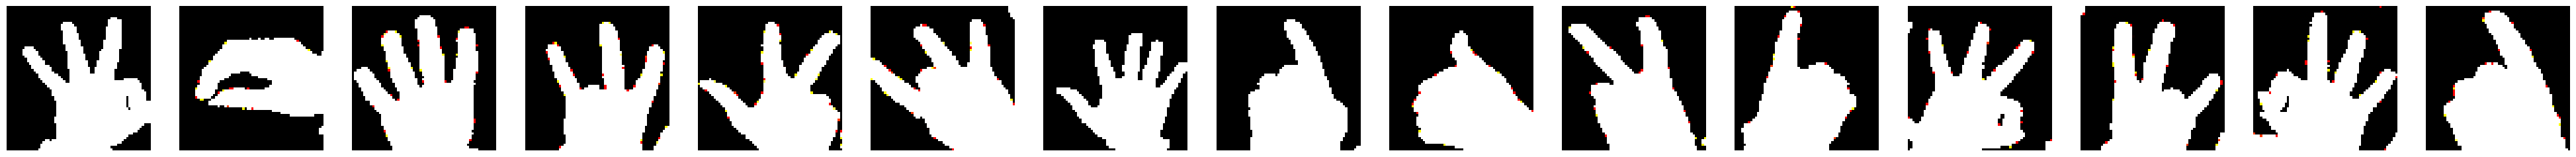

Nine  Zero  Four  Seven  Three  Eight  Five  One  Ten  Two  One  Nine  Seven  Nine  One  
 (64, 64, 3)


In [5]:
words = {0:'Zero', 1:'One', 2:'Two', 3:'Three', 4:'Four', 5:'Five', 6:'Six', 7:'Seven', 8:'Eight', 9:'Nine', 10:'Ten'}

display(images_train)
# labels_train

def digits(labels):
    for label in labels:
        print(words[np.argmax(label)], end='  ')
        
        
digits(labels_train)

print('\n', images_test[0].shape)

# Create CNN Model:

In [6]:
# Convolutional Neural Network

def createModel():
    model = Sequential()
    # number of features , kernel is found all pixel in image   
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    # for freeze and dropout some node 
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    
    # output layer
    model.add(Dense(11, activation='softmax'))
    
    return model

model = createModel()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       7

# Training CNN Model:

In [7]:
# model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, mode='auto', verbose=0)

In [8]:
# history = model.fit(train_data_batches, epochs=100, callbacks=[reduceLR, early_stop], validation_data=test_data_batches, shuffle=True)
history = model.fit(train_data_batches, epochs=20, validation_data=test_data_batches, shuffle=True)

Epoch 1/20
1907/1907 [==============================] - 509s 264ms/step - loss: 0.6367 - accuracy: 0.8022 - val_loss: 0.6829 - val_accuracy: 0.8132
Epoch 2/20
1907/1907 [==============================] - 383s 201ms/step - loss: 0.1167 - accuracy: 0.9661 - val_loss: 0.4722 - val_accuracy: 0.8751
Epoch 3/20
1907/1907 [==============================] - 415s 218ms/step - loss: 0.0902 - accuracy: 0.9756 - val_loss: 0.4555 - val_accuracy: 0.8671
Epoch 4/20
1907/1907 [==============================] - 377s 198ms/step - loss: 0.0806 - accuracy: 0.9794 - val_loss: 0.2961 - val_accuracy: 0.9133
Epoch 5/20
1907/1907 [==============================] - 683s 358ms/step - loss: 0.0681 - accuracy: 0.9836 - val_loss: 0.8018 - val_accuracy: 0.8845
Epoch 6/20
1907/1907 [==============================] - 481s 252ms/step - loss: 0.0533 - accuracy: 0.9871 - val_loss: 0.5339 - val_accuracy: 0.9089
Epoch 7/20
1907/1907 [==============================] - 408s 214ms/step - loss: 0.0635 - accuracy: 0.9856 - val_

# Testing:

In [9]:
scores = model.evaluate(images_test, labels_test, verbose=0)

print(
    f'{model.metrics_names[0]} = {np.round(scores[0], 1)} || {model.metrics_names[1]} = {np.round(scores[1], 1)*100}%')

loss = 0.2 || accuracy = 90.0%


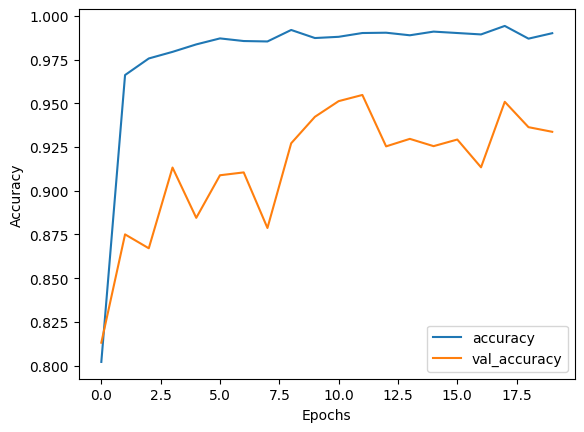

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

In [11]:
model.save('SignLanguageModel4.hs')

# model2 = tf.keras.models.load_model('E:\project\SignLanguageModel.hs')

INFO:tensorflow:Assets written to: SignLanguageModel4.hs\assets


INFO:tensorflow:Assets written to: SignLanguageModel4.hs\assets


In [9]:
import tensorflow as tf
import cv2
import numpy as np
import os
import glob as gb

In [16]:
def segmentation(frame, threshold=20):
    global background
    
    difference = cv2.absdiff(background.astype('uint8'), frame)
    
    _, processed_frame = cv2.threshold(difference, threshold, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(processed_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        contours = max(contours, key=cv2.contourArea)
    
    return processed_frame, contours


cam = cv2.VideoCapture(0)

# roi : region of interest

top = 50

bottom = 300

right = 50

left = 250


background = None

count = 0

digit = 0

sample_number = 0
words = {
    0: 'Zero', 1: 'One', 2: 'Two', 3: 'Three', 4: 'Four',
    5: 'Five', 6: 'Six', 7: 'Seven', 8: 'Eight', 9: 'Nine', 10: 'Ten'
}


model = tf.keras.models.load_model(
    'SignLanguageModel.hs')



while True:
    value, frame = cam.read()

    frameCopy = frame.copy()

    frameCopy = cv2.flip(frameCopy, 1)


    roi = frameCopy[top:bottom, right:left]

    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    roi_blur = cv2.GaussianBlur(roi_gray, (9, 9), 0)


    if background is None:

        background = roi_blur.copy().astype('float')


    cv2.rectangle(frameCopy, (left, top), (right, bottom), (0, 0, 255), 3)


    if count < 30:

        cv2.accumulateWeighted(roi_blur, background, 0.5)

        cv2.putText(frameCopy, 'Loading...', (250, 250),

                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)


    collection = segmentation(roi_blur)


    k = cv2.waitKey(1)

    if collection is not None:
        roi_processed, contour = collection

        cv2.drawContours(frameCopy, [contour+(right, top)], -1, (0, 255, 0), 2)
        

        # aaa

        roi_processed = cv2.resize(roi_processed, (64, 64))

        roi_processed = cv2.cvtColor(roi_processed, cv2.COLOR_GRAY2RGB)

        frame = np.reshape(roi_processed, (1, roi_processed.shape[0], roi_processed.shape[1], 3))
        value = model.predict(frame)

        label = words[np.argmax(value)]

        cv2.putText(frameCopy, str(label), (370, 145), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
        
    


        cv2.imshow('Segmentation', roi_processed)


    count += 1


    cv2.imshow('Camera', frameCopy)


    if k == 27:

        break
    


cv2.destroyAllWindows()
cam.release()

1/1 [==============================] - 0s 46ms/step


In [12]:
x_predict = []

files = gb.glob(pathname=str('predict_data' + '/*.jpg'))

for file in files:
    image = cv2.imread(file)
    image_array = cv2.resize(image, (64, 64))
    x_predict.append(list(image_array))

In [16]:
x_predict[0]

[array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 

In [13]:
words = {
    0: 'Zero', 1: 'One', 2: 'Two', 3: 'Three', 4: 'Four',
    5: 'Five', 6: 'Six', 7: 'Seven', 8: 'Eight', 9: 'Nine', 10: 'Ten'
}
y_predict = []
for image in x_predict:
    
    model = tf.keras.models.load_model(
        'SignLanguageModel4.hs')

    frame = np.reshape(image, (1, 64, 64, 3))


    value = model.predict(frame)

    label = words[np.argmax(value)]
    y_predict.append(label)

 

1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 196ms/step


1/1 [==============================] - 0s 223ms/step


In [14]:
y_predict

['Ten',
 'Seven',
 'Four',
 'Four',
 'Five',
 'Four',
 'Nine',
 'Nine',
 'Nine',
 'Ten',
 'Zero']

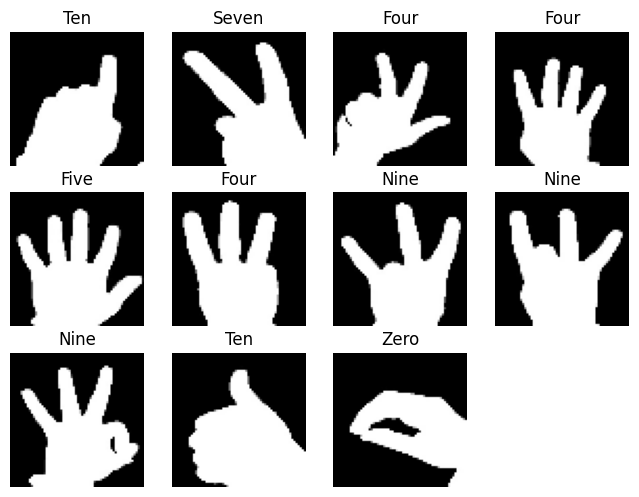

In [15]:
plt.figure(figsize=(8, 8))
for num, value in enumerate(x_predict):
    plt.subplot(4, 4, num+1)
    plt.imshow(value)
    plt.axis('off')
    plt.title(y_predict[num])